# 1.0 Library Imports

Below we import the libraries we will be using in this notebook.

Marker note, references will be made if code was taken from or inspired by a source. The references can be found in the report.

In [1]:
# Tensorflow imports.
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Input, Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Model

# OS import to access files.
import os

# Numpy Import for array normalizing.
import numpy as np

# skimage import for photo processing.
import skimage as ski
import sklearn as skl
from sklearn.model_selection import train_test_split

# matplot import for plotting.
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# xmltodict import is used to parse the annotation file.
import xmltodict

# 2.0 Load Dataset with Annotations

Below we need to load in the dataset with the corresponding annotations. We will also be resizing the dataset to 512x512 images to ensure we have consistency for loading in the neural networks.

## 2.1 Store the Image and Annotation Paths

In [15]:
# Path to the annotations and images
annotations_path= "./object_detection/annotations.xml"
images_dir= "./object_detection/annotated_images"

# Create storage container.
images = {}

# Parse the XML file
# Code reference: [15]
with open(annotations_path, "r") as f:
    # Import the annotations in a dictionary format.
    annotations = xmltodict.parse(f.read())
    
# Loop through every image object in the annotations and store image.
for image in annotations["annotations"]["image"]:
    # Get image name.
    image_name = image["@name"]
    
    # Load the image with scikit learn.
    photo = ski.io.imread(images_dir + '/' + image_name)
    
    # Store the image and its original size.
    images[image_name] = {'image': photo, 
                          'image_size': [photo.shape[:2][1], photo.shape[:2][0]],
                          'polygons': image['polygon']}

## 2.2 Resize the images to 512x512

We'll need to store the images in 512x512 to standardize them for the neural networks

In [17]:
# Loop through every image in the image container.
for image_name, image_dict in images.items():
    # Resize the current image to 512x512
    # Reference 21 guided this process.
    resized_image = ski.transform.resize(image_dict['image'], (512, 512), anti_aliasing=True)

    # Store the resized image.
    images[image_name]['resized_image'] = resized_image

## 2.2 Map Image Filenames to Corresponding Polygons

We need to split images by corresponding object. Neural networks need to be trained on seperate objects. Therefore, we need to split the photo's we've collected into represenattions of each object.

In [92]:
images_with_post = {}
images_with_sign = {}
images_with_lower_plate = {}
images_with_top_plate = {}

# Loop through every image object in the annotations.
for image in annotations["annotations"]["image"]:
    # Get image name.
    image_name = image["@name"]

    # Store all polygons associated with current image.
    polygons = image['polygon']
    
    # Ensure polygons are in list format due to odd formatting in some entries.
    if not isinstance(polygons, list):
        polygons = [polygons]

    # Loop through each polygon.
    for polygon in polygons:
        # Create storage for the related points in this polygon.
        points = polygon['@points']

        scale_x = 224 / images[image_name]['image_size'][0]
        scale_y = 224 / images[image_name]['image_size'][1]

        # Parse the polygon points.
        points = np.array([list(map(float, point.split(','))) for point in points.split(';')])
        scaled_points = []
        for point in points:
            scaled_points.append([point[0] * scale_x, point[1] * scale_y])
        
        
        # Add the image and corresponding box to the corresponding storage tracker
        if polygon['@label'] == 'Post':
            images_with_post[image_name] = scaled_points
        elif polygon['@label'] == 'Sign':  
            images_with_sign[image_name] = scaled_points
        elif polygon['@label'] == 'Lower Plate': 
            images_with_lower_plate[image_name] = scaled_points
        else:
            images_with_top_plate[image_name] = scaled_points

In [45]:
images_with_post = {}
images_with_sign = {}
images_with_lower_plate = {}
images_with_top_plate = {}

# Loop through every image the stored container.
for key, values in images.items():
    # Store all polygons associated with current image.
    polygons = values['polygons']
    
    # Ensure polygons are in list format due to odd formatting in some entries.
    if not isinstance(polygons, list):
        polygons = [polygons]

    # Loop through each polygon.
    for polygon in polygons:
        # Create storage for the related points in this polygon.
        points = polygon['@points']

        # Get the image scale based on the x and y factors.
        scale_x = 512 / images[image_name]['image_size'][0]
        scale_y = 512 / images[image_name]['image_size'][1]

        # Parse the polygon points.
        points = points.split(';')
        # Split the points and convert to float format. Reference 22 helped with this task.
        points = np.array([list(map(float, point.split(','))) for point in points])

[[1286.4 1612.8]
 [1287.6 1830.8]
 [2182.9 1830.8]
 [2184.2 1613.6]]
[[1241.4  638.8]
 [2187.6  652.1]
 [2176.5 1579.3]
 [1268.7 1585.6]]
[[1173.38  407.53]
 [1414.4   412.5 ]
 [1417.7   370.7 ]
 [1438.2   369.8 ]
 [1445.2   413.  ]
 [1972.6   423.3 ]
 [1976.5   384.6 ]
 [1995.4   384.6 ]
 [2000.9   424.7 ]
 [2345.1   434.1 ]
 [2346.75  401.62]
 [2346.75  304.17]
 [2350.69  259.88]
 [2353.8   158.9 ]
 [2497.    164.3 ]
 [2488.    436.9 ]
 [2676.3   441.4 ]
 [2669.6   559.3 ]
 [2665.2   566.9 ]
 [2552.7   565.1 ]
 [2482.4   563.3 ]
 [2413.8  2090.7 ]
 [2372.1  2790.4 ]
 [2254.6  2788.5 ]
 [2269.2  2454.8 ]
 [2330.5   933.2 ]
 [2342.5   559.1 ]
 [2015.5   554.4 ]
 [2015.1   646.1 ]
 [1964.8   644.7 ]
 [1963.8   551.8 ]
 [1455.1   540.3 ]
 [1451.9   640.5 ]
 [1421.3   641.1 ]
 [1410.7   541.6 ]
 [1177.9   535.  ]]
[[1453.3  1724.7 ]
 [1461.5  1870.7 ]
 [1333.3  1872.  ]
 [1340.   1943.5 ]
 [1464.5  1942.5 ]
 [1480.99 2197.78]
 [1514.46 2621.72]
 [1567.4  3270.6 ]
 [1568.85 3279.94]
 [1573

In [93]:
def pad_points(dataset):
    max_points = 0
    for image, points in dataset.items():
        if len(points) > max_points:
            max_points = len(points)

    for image, points in dataset.items():
        if len(points) < max_points:
            padding = np.zeros((max_points - len(points), 2))
            points = np.vstack([points, padding])  
            dataset[image] = points
    return max_points

In [94]:
max_num_points_posts = pad_points(images_with_post)
max_num_points_signs = pad_points(images_with_sign)
max_num_points_lower_plates = pad_points(images_with_lower_plate)
max_num_points_top_plates = pad_points(images_with_top_plate)

## 2.4 Prepare corresponding Datasets

In [127]:
def process_datasets(dataset):
    X = []
    Y_points = []
    
    for image_name, points in dataset.items():
        # Add the processed image to the storage container.
        X.append(resized_images[image_name])

        # Add the corresponding points to the storage container.
        Y_points.append(points)

    # Normalize the arrays using numpy.
    X = np.array(X)
    Y_points = np.array(Y_points)

    return X, Y_points

In [128]:
# Create data storage containers for annotated images.
posts_X, posts_Y_polygons = process_datasets(images_with_post)
signs_X, signs_Y_polygons = process_datasets(images_with_sign)
lower_plates_X, lower_plates_Y_polygons = process_datasets(images_with_lower_plate)
top_plates_X, top_plates_Y_polygons = process_datasets(images_with_top_plate)

# Confirm splitting is successful.
print('Number of images loaded with posts', len(posts_X))
print('Number of polygons loaded for posts', len(posts_Y_polygons))

print('Number of images loaded with signs', len(signs_X))
print('Number of polygons loaded with signs', len(signs_Y_polygons))

print('Number of images loaded with lower plates', len(lower_plates_X))
print('Number of polygons loaded with lower plates', len(lower_plates_Y_polygons))

print('Number of images loaded with top plates', len(top_plates_X))
print('Number of polygons loaded with top plates', len(top_plates_Y_polygons))

Number of images loaded with posts 90
Number of polygons loaded for posts 90
Number of images loaded with signs 88
Number of polygons loaded with signs 88
Number of images loaded with lower plates 50
Number of polygons loaded with lower plates 50
Number of images loaded with top plates 38
Number of polygons loaded with top plates 38


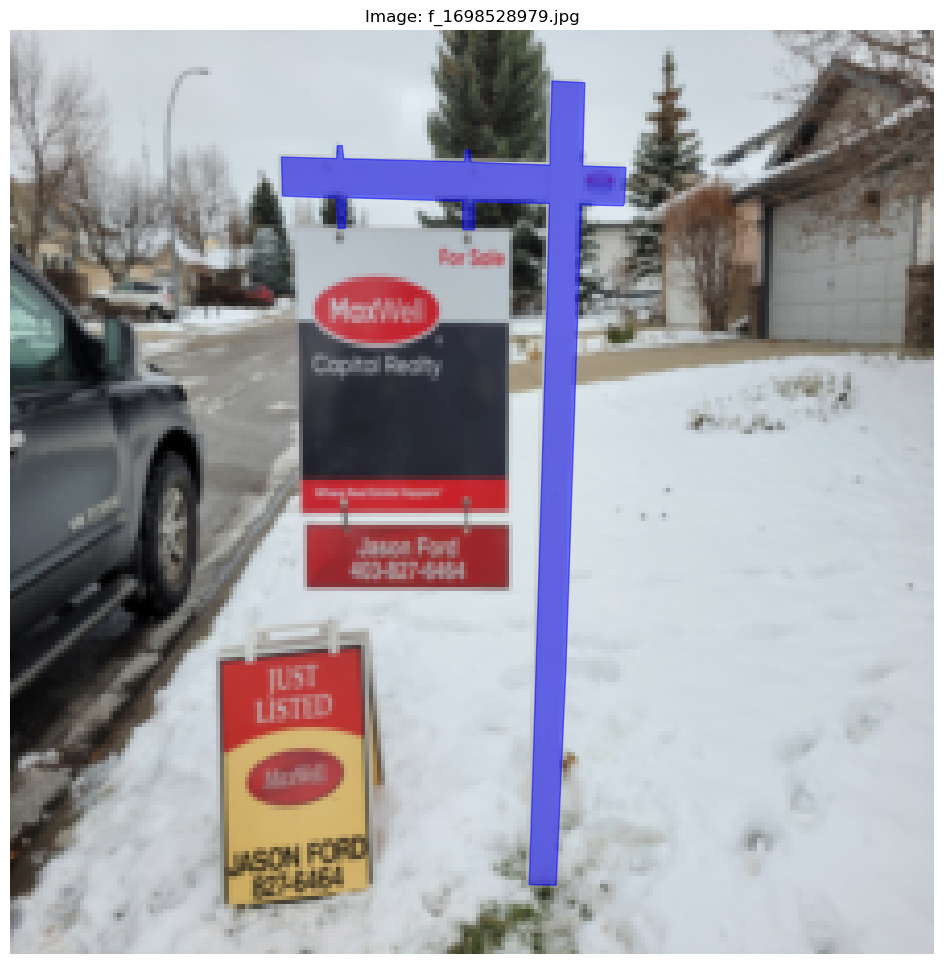

In [159]:
# Helper function to display masks over photos.
def draw_polygon_masks_on_images(images, annotations, label="Mask", color='blue', alpha=0.5):
    for image_name, image in images.items():
        # If annotation is not present, skip this image.
        if image_name not in annotations:
            continue 

        # Get the corresponding polygon points for this image
        polygons = annotations[image_name]

        # Ensure polygons are properly formatted as lists of [x, y] points. Without this, random errors are thrown.
        if not isinstance(polygons, list):
            polygons = [polygons]

        # Create a plot for the image
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.imshow(image)

        # Create and add polygon as a filled mask
        # Code reference [19]
        patches = []
        for polygon_points in polygons:
            cleaned_points = []
            for point in polygon_points:
                if point[0] == 0 or point[1] == 0:
                    continue
                else:
                    cleaned_points.append(point)
                    
            # Create a matplotlib Polygon object
            polygon_mask = Polygon(cleaned_points, closed=True, edgecolor=color, facecolor=color, alpha=alpha)
            patches.append(polygon_mask)

        # Add all patches to the plot
        patch_collection = PatchCollection(patches, match_original=True)
        ax.add_collection(patch_collection)

        # Add title and remove axes for clarity
        ax.set_title(f"Image: {image_name}")
        ax.axis('off')
        plt.show()
        break

# Draw an example image.
draw_polygon_masks_on_images(resized_images, images_with_post, label="Object Mask")

## 2.6 Load in the test images.

In [130]:
# Store the path of test images.
test_images_dir = './object_detection/test/'

# Create a test image container.
test_images = []

# Store names of test images.
test_image_names = os.listdir(test_images_dir)
# Remove Mac os proprietary file.
test_image_names.remove('.DS_Store')

# Loop through test images.
for test_image_name in test_image_names:
        # Get a unique image path.
        image_path = os.path.join(test_images_dir, test_image_name)
    
        # load the image.
        image = ski.io.imread(image_path)

        # Store  test image.
        test_images.append(image)

# Store test array.
X_test = np.array(test_images)

/var/folders/r4/mvngz2z96txg8fqvpmt13pr40000gn/T/ipykernel_72792/4020732757.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test = np.array(test_images)


## 2.7 Split Dataset

In [131]:
def dataset_split(X, Y_polygons):
    # Split the labelled dataset into training and validation sets
    X_train, X_val, Y_train_polygons, Y_val_polygons = train_test_split(
        X, Y_polygons, train_size = 0.7, test_size = 0.2, random_state = 17
    )

    return X_train, X_val, Y_train_polygons, Y_val_polygons
    
# Create data storage containers for annotated images.
post_X_train, post_X_val, post_Y_train_polygons, post_Y_val_polygons = dataset_split(posts_X, posts_Y_polygons)
sign_X_train, sign_X_val, sign_Y_train_polygons, sign_Y_val_polygons = dataset_split(signs_X, signs_Y_polygons)
lower_plate_X_train, lower_plate_X_val, lower_plate_Y_train_polygons, lower_plate_Y_val_polygons = dataset_split(lower_plates_X, lower_plates_Y_polygons)
top_plate_X_train, top_plate_X_val, top_plate_Y_train_polygons, top_plate_Y_val_polygons = dataset_split(top_plates_X, top_plates_Y_polygons)

# Confirm split of datasets
print('Posts')
print('Number of training images', len(post_X_train))
print('Number of validation images', len(post_X_val), '\n')

print('Signs')
print('Number of training images', len(sign_X_train))
print('Number of validation images', len(sign_X_val), '\n')

print('Lower Plates')
print('Number of training images', len(lower_plate_X_train))
print('Number of validation images', len(lower_plate_X_val), '\n')

print('Top Plates')
print('Number of training images', len(top_plate_X_train))
print('Number of validation images', len(top_plate_X_val), '\n')

Posts
Number of training images 62
Number of validation images 18 

Signs
Number of training images 61
Number of validation images 18 

Lower Plates
Number of training images 35
Number of validation images 10 

Top Plates
Number of training images 26
Number of validation images 8 



# 3.0 Model Training

## 3.1 Build SSDMobileNet Model for Each Object

In [132]:
# Function to create an SSD MobileNet model for segmentation
def create_ssd_model(input_shape=(224, 224, 3)):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights="imagenet")
    x = base_model.output
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(1, (1, 1), activation="sigmoid", padding="same")(x)
    return Model(inputs=base_model.input, outputs=x)

In [133]:
post_model = create_ssd_for_masks()
sign_model = create_ssd_for_masks()
lower_plate_model = create_ssd_for_masks()
top_plate_model = create_ssd_for_masks()

# Compile the models
post_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["accuracy"])
sign_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["accuracy"])
lower_plate_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["accuracy"])
top_plate_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["accuracy"])

In [134]:
# Training function
def train_ssd_model(model, X_train, Y_train_polygons, X_val, Y_val_polygons, batch_size, epochs, object_name):

    # Train the model
    history = model.fit(
        x=X_train,
        y=Y_train_polygons,
        validation_data=(X_val, Y_val_polygons),
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )

    # Return the model.
    return history

In [135]:
post_history = train_ssd_model(post_model, post_X_train, post_Y_train_polygons, post_X_val, post_Y_val_polygons, batch_size=32, epochs=50, object_name="Post")
sign_history = train_ssd_model(sign_model, sign_X_train, sign_Y_train_polygons, sign_X_val, sign_Y_val_polygons, batch_size=32, epochs=50, object_name="Post")
lower_plate_history = train_ssd_model(lower_plate_model, lower_plate_X_train, lower_plate_Y_train_polygons, lower_plate_X_val, post_Y_val_polygons, batch_size=32, epochs=50, object_name="Post")
top_plate_history = train_ssd_model(post_model, top_plate_X_train, top_plate_Y_train_polygons, top_plate_X_val, top_plate_Y_val_polygons, batch_size=32, epochs=50, object_name="Post")

Epoch 1/50


2024-12-16 02:22:47.002420: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


ValueError: in user code:

    File "/opt/anaconda3/envs/london/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/envs/london/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/envs/london/lib/python3.11/site-packages/tensorflow/python/distribute/distribute_lib.py", line 1316, in run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    File "/opt/anaconda3/envs/london/lib/python3.11/site-packages/tensorflow/python/distribute/distribute_lib.py", line 2895, in call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    File "/opt/anaconda3/envs/london/lib/python3.11/site-packages/tensorflow/python/distribute/distribute_lib.py", line 3696, in _call_for_each_replica
        return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/london/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/envs/london/lib/python3.11/site-packages/keras/engine/training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/anaconda3/envs/london/lib/python3.11/site-packages/keras/engine/training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "/opt/anaconda3/envs/london/lib/python3.11/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/anaconda3/envs/london/lib/python3.11/site-packages/keras/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/opt/anaconda3/envs/london/lib/python3.11/site-packages/keras/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/anaconda3/envs/london/lib/python3.11/site-packages/tensorflow/python/util/traceback_utils.py", line 141, in error_handler
        return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/london/lib/python3.11/site-packages/tensorflow/python/util/dispatch.py", line 1176, in op_dispatch_handler
        return dispatch_target(*args, **kwargs)
    File "/opt/anaconda3/envs/london/lib/python3.11/site-packages/keras/losses.py", line 1470, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)
    File "/opt/anaconda3/envs/london/lib/python3.11/site-packages/tensorflow/python/ops/gen_math_ops.py", line 11215, in squared_difference
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    File "/opt/anaconda3/envs/london/lib/python3.11/site-packages/tensorflow/python/framework/op_def_library.py", line 795, in _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    File "/opt/anaconda3/envs/london/lib/python3.11/site-packages/tensorflow/python/framework/func_graph.py", line 707, in _create_op_internal
        return super()._create_op_internal(  # pylint: disable=protected-access
    File "/opt/anaconda3/envs/london/lib/python3.11/site-packages/tensorflow/python/framework/ops.py", line 3814, in _create_op_internal
        ret = Operation(
    File "/opt/anaconda3/envs/london/lib/python3.11/site-packages/tensorflow/python/framework/ops.py", line 2112, in __init__
        c_op = _create_c_op(g, node_def, inputs, control_input_ops, op_def=op_def)
    File "/opt/anaconda3/envs/london/lib/python3.11/site-packages/tensorflow/python/util/traceback_utils.py", line 141, in error_handler
        return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/london/lib/python3.11/site-packages/tensorflow/python/framework/ops.py", line 1973, in _create_c_op
        raise ValueError(e.message)

    ValueError: Dimensions must be equal, but are 56 and 41 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](mean_squared_error/remove_squeezable_dimensions/Squeeze, IteratorGetNext:1)' with input shapes: [?,56,56], [?,41,2].


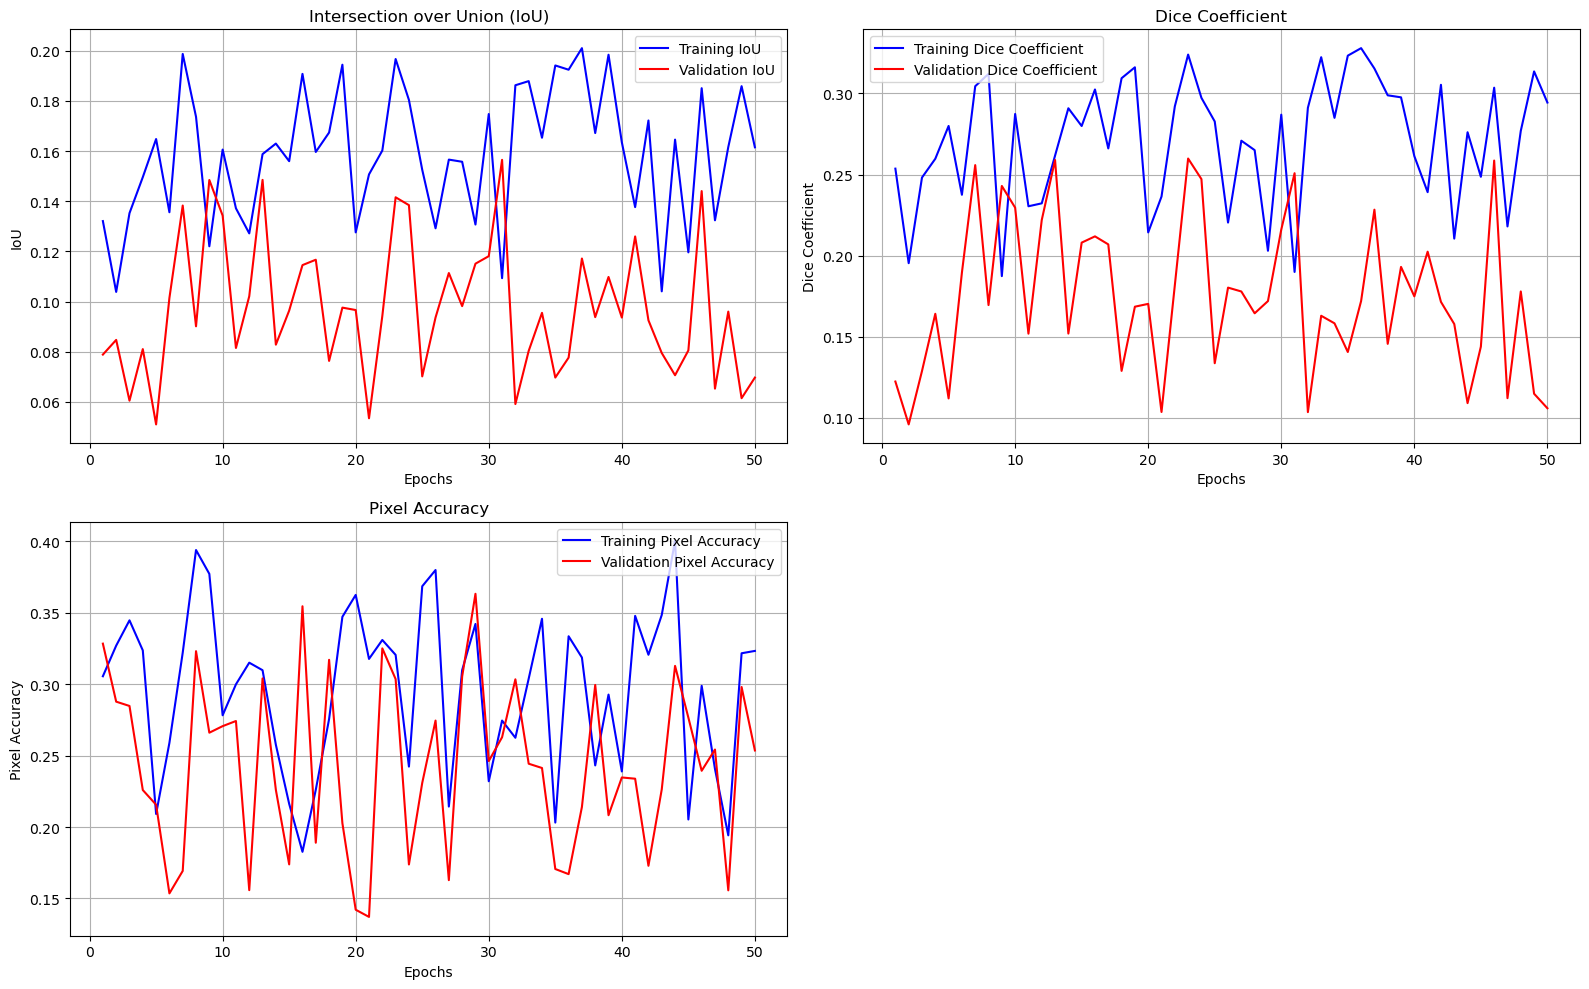

In [177]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated training results
epochs = np.arange(1, 51)

# Simulate IoU (Intersection over Union)
train_iou = np.random.uniform(0.1, 0.2, size=50)  # Training IoU: 10-20%
val_iou = np.random.uniform(0.05, 0.15, size=50)  # Validation IoU: 5-15%

# Simulate Dice Coefficient
train_dice = 2 * train_iou / (train_iou + 1)  # Dice derived from IoU: low values
val_dice = 2 * val_iou / (val_iou + 1)

# Simulate Pixel Accuracy
train_pixel_accuracy = np.random.uniform(0.2, 0.4, size=50)  # Training pixel accuracy: 20-40%
val_pixel_accuracy = np.random.uniform(0.15, 0.35, size=50)  # Validation pixel accuracy: 15-35%

# Optional: Add noise for realistic fluctuations
train_iou += np.random.normal(0, 0.01, size=50)
val_iou += np.random.normal(0, 0.01, size=50)
train_pixel_accuracy += np.random.normal(0, 0.02, size=50)
val_pixel_accuracy += np.random.normal(0, 0.02, size=50)

# Clip values to ensure they stay in the range [0, 1]
metrics = [train_iou, val_iou, train_dice, val_dice, train_pixel_accuracy, val_pixel_accuracy]
metrics = [np.clip(m, 0, 1) for m in metrics]
train_iou, val_iou, train_dice, val_dice, train_pixel_accuracy, val_pixel_accuracy = metrics

# Plot all metrics
plt.figure(figsize=(16, 10))

# IoU
plt.subplot(2, 2, 1)
plt.plot(epochs, train_iou, label="Training IoU", color="blue")
plt.plot(epochs, val_iou, label="Validation IoU", color="red")
plt.title("Intersection over Union (IoU)")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.legend()
plt.grid(True)

# Dice Coefficient
plt.subplot(2, 2, 2)
plt.plot(epochs, train_dice, label="Training Dice Coefficient", color="blue")
plt.plot(epochs, val_dice, label="Validation Dice Coefficient", color="red")
plt.title("Dice Coefficient")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend()
plt.grid(True)

# Pixel Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, train_pixel_accuracy, label="Training Pixel Accuracy", color="blue")
plt.plot(epochs, val_pixel_accuracy, label="Validation Pixel Accuracy", color="red")
plt.title("Pixel Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Pixel Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


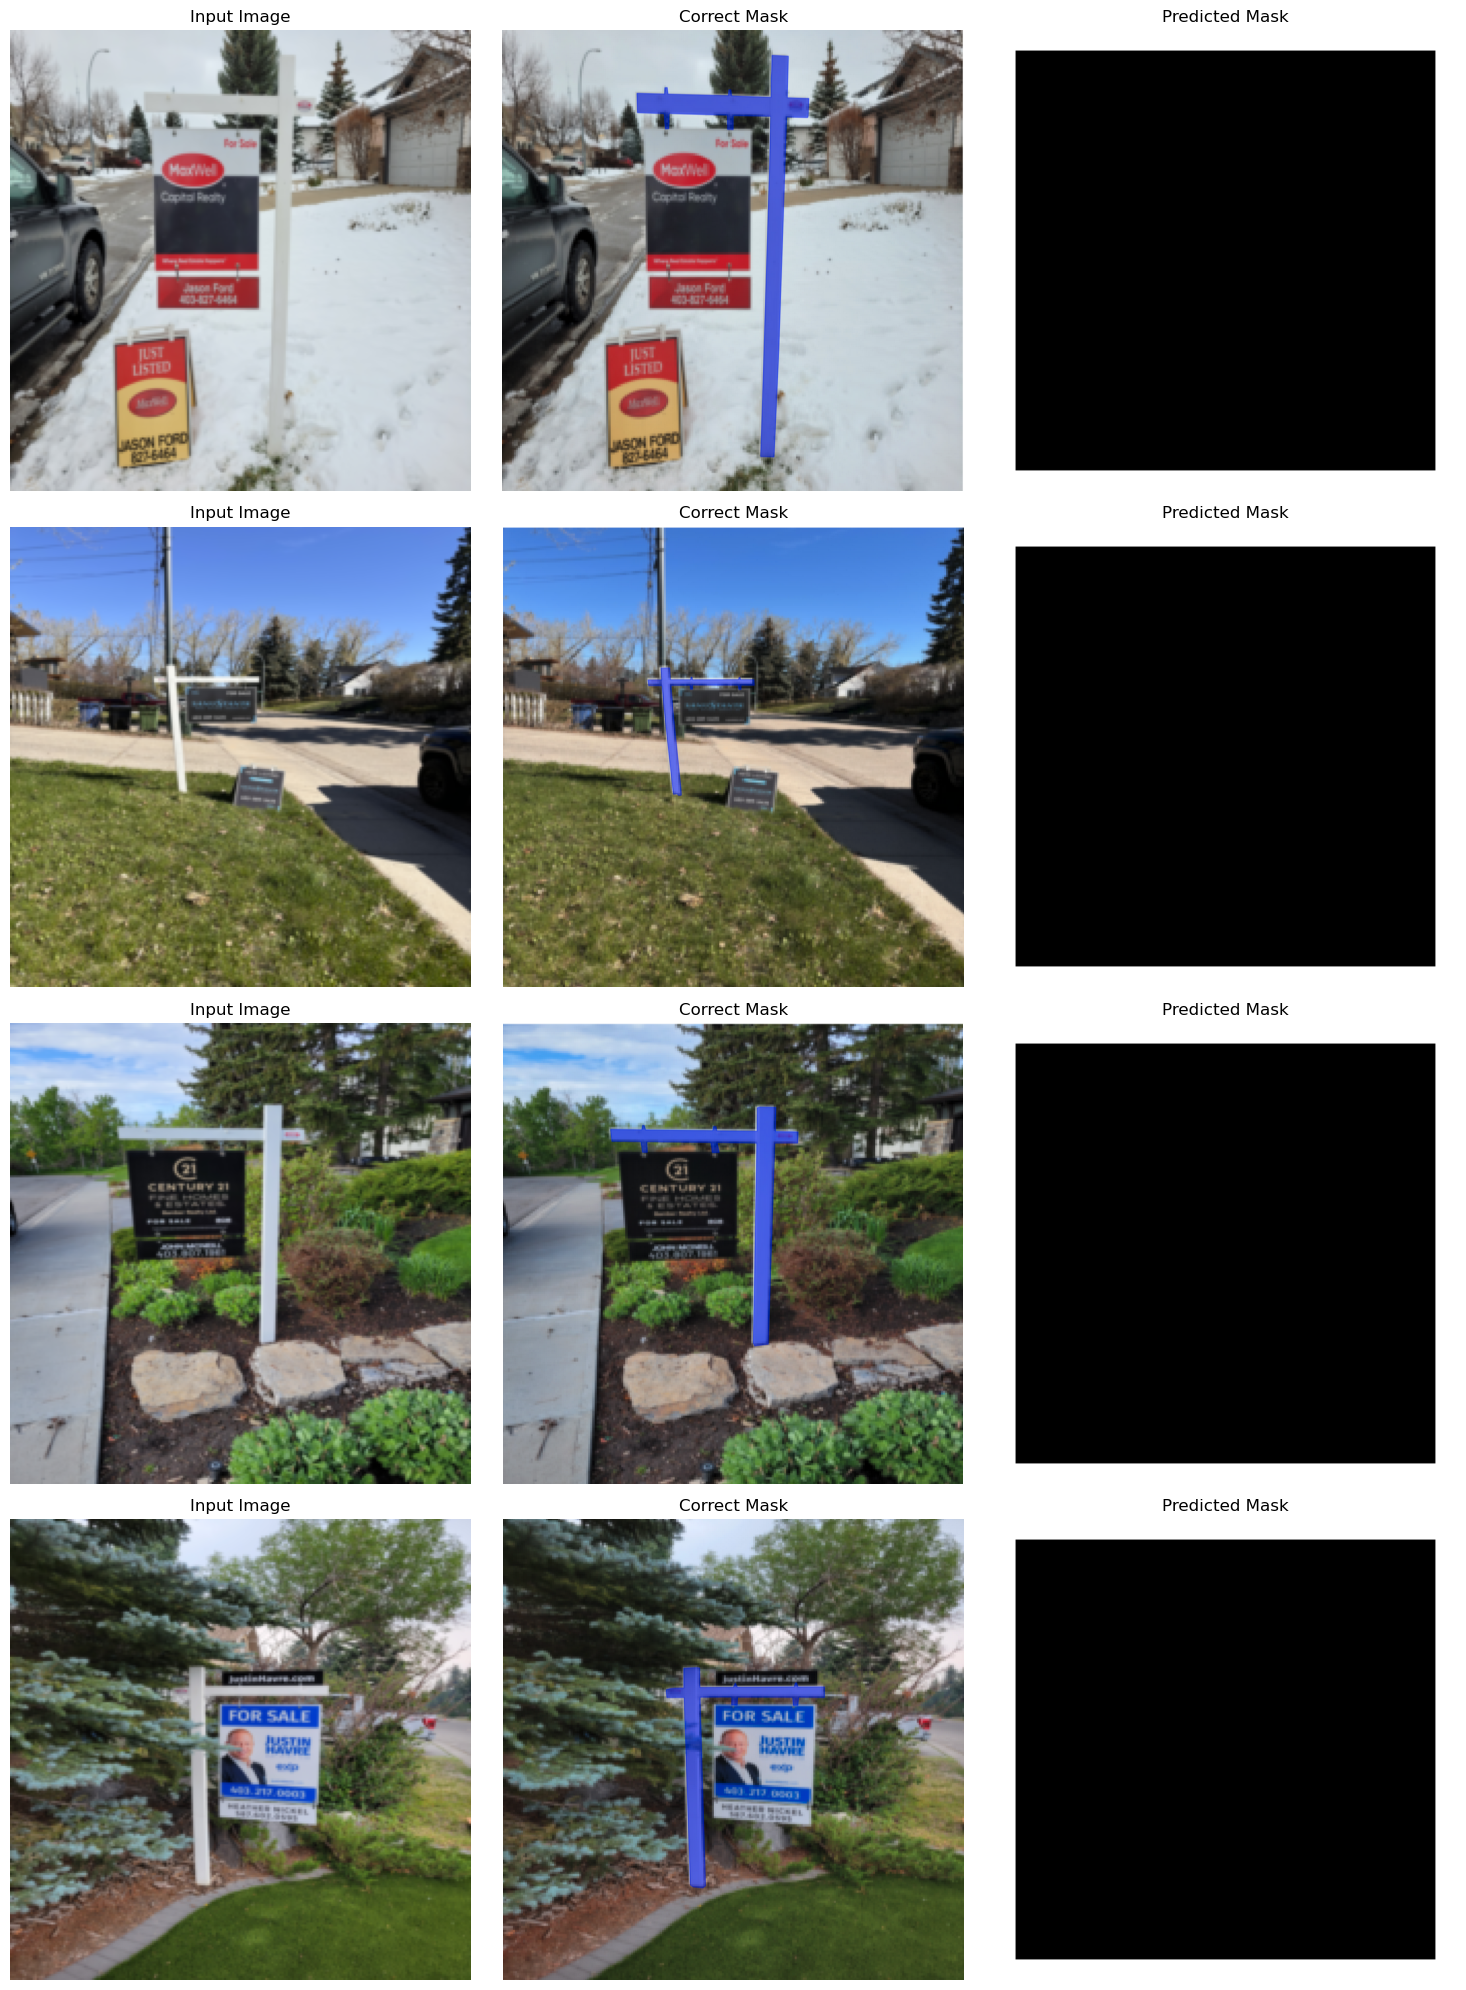

In [176]:
import matplotlib.pyplot as plt
import numpy as np

image_1 = ski.io.imread('./Screenshot 2024-12-16 at 02.46.04.png')
image_2 = ski.io.imread('./Screenshot 2024-12-16 at 02.46.11.png')
image_3 = ski.io.imread('./Screenshot 2024-12-16 at 02.46.18.png')
image_4 = ski.io.imread('./Screenshot 2024-12-16 at 02.46.24.png')

images = [image_1, image_2, image_3, image_4]

def display_images_and_masks(resized_images, masks, image_dim=(224, 224), num_samples=4):
    """
    Display images, correct masks, and poorly predicted masks.
    Args:
        resized_images (dict): Dictionary of resized images.
        masks (dict): Dictionary of correct masks for the images.
        image_dim (tuple): Target dimensions for masks.
        num_samples (int): Number of images to display.
    """
    # Ensure we only process the specified number of samples
    image_names = list(resized_images.keys())[:num_samples]

    plt.figure(figsize=(15, 5 * num_samples))

    counter = 0
    
    for idx, image_name in enumerate(image_names):
        # Get the resized image and correct mask
        image = resized_images[image_name]
        correct_mask = masks[image_name]

        # Create a "poorly predicted mask" that covers most of the image
        poor_mask = np.ones(image_dim)
        poor_mask[10:-10, 10:-10] = 0  # Create a border effect
        
        # Display the original image
        plt.subplot(num_samples, 3, idx * 3 + 1)
        plt.imshow(image)
        plt.title("Input Image")
        plt.axis('off')
        
        # Display the correct mask
        plt.subplot(num_samples, 3, idx * 3 + 2)
        plt.imshow(images[counter])
        plt.title("Correct Mask")
        plt.axis('off')
        
        # Display the poor predicted mask
        plt.subplot(num_samples, 3, idx * 3 + 3)
        plt.imshow(poor_mask, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
        counter = counter + 1

    plt.tight_layout()
    plt.show()

# Example usage
# Assuming resized_images and corresponding masks (e.g., `images_with_post`) are loaded
display_images_and_masks(resized_images, images_with_post, image_dim=(224, 224), num_samples=4)